# Comparing Model Performance after Fine-Tuning
In this example, we will take the pre-existing SageMaker endpoints that you deployed in previous exercises and use them to generate data that can be leveraged for quality comparison. This data can be used to take a quantitative approach to judge the efficacy of fine-tuning your models.

This example will run through samples of the medical-o1-reasoning dataset (FreedomIntelligence/medical-o1-reasoning-SFT) on the Hugging Face data hub for medical Q&A and use the [lighteval](https://huggingface.co/docs/lighteval/index) from Hugging Face for analysis.

## Prerequisites

In [2]:
%pip install -r ./scripts/requirements.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 210.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 182.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 151.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 105.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 175.0 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 186.2 MB/s  0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24987 sha256=2f69b214381626f75472a71df53f21d9922cbb53b2f6074bd9d20ff9e9062502
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
  Attempting u

## This cell will restart the kernel. Click "OK".

In [3]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
BASE_ENDPOINT_NAME = "Qwen3-4B-Instruct-2507-endpoint-2026-02-13-13-13-09-563"
TUNED_ENDPOINT_NAME = "Qwen3-4B-Instruct-2507-sft-2026-02-13-19-22-36-498"

%store BASE_ENDPOINT_NAME
%store TUNED_ENDPOINT_NAME

# Import libraries
import os
import json
import time
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import load_dataset

# Import LightEval metrics
from lighteval.metrics.metrics_sample import ROUGE, Doc

Stored 'BASE_ENDPOINT_NAME' (str)
Stored 'TUNED_ENDPOINT_NAME' (str)
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### Fetch the saved endpoint names from previous sections, or set them manually by uncommenting the code below. 

In [2]:
%store -r BASE_ENDPOINT_NAME
%store -r TUNED_ENDPOINT_NAME

#BASE_ENDPOINT_NAME = ""
#TUNED_ENDPOINT_NAME = ""

print(f"Base Endpoint: {BASE_ENDPOINT_NAME}")
print(f"Tuned Endpoint: {TUNED_ENDPOINT_NAME}")

Base Endpoint: Qwen3-4B-Instruct-2507-endpoint-2026-02-13-13-13-09-563
Tuned Endpoint: Qwen3-4B-Instruct-2507-sft-2026-02-13-19-22-36-498


In [3]:
# Define the model to evaluate
model_to_evaluate = {
    "name": "Fine-tuned Model", 
    "endpoint": TUNED_ENDPOINT_NAME
}

Here you will use the the medical-o1-reasoning dataset. The dataset is pre-split into training and test data. We will limit the number of samples to evaluate for the fine-tuned and base models.

In [4]:
# Limit the number of samples to evaluate (for faster execution)
num_samples = 10

# Load the test split of the medical-o1-reasoning dataset
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en", split="train")

max_samples = len(dataset)

dataset = dataset.shuffle().select(range(min(num_samples, max_samples)))
print(f"Loaded medical-o1-reasoning dataset with {len(dataset)} samples out of {max_samples}")

# Display a sample from the dataset
sample = dataset[0]

print("\nQuestion:\n", sample["Question"], "\n\n====\n")
print("Complex_CoT:\n", sample["Complex_CoT"], "\n\n====\n")
print("Response:\n", sample["Response"], "\n\n====\n")

README.md: 0.00B [00:00, ?B/s]

medical_o1_sft.json:   0%|          | 0.00/58.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19704 [00:00<?, ? examples/s]

Loaded medical-o1-reasoning dataset with 10 samples out of 19704

Question:
 Which hereditary disorder of bilirubin metabolism is caused by a defect in the MRP2 gene? 

====

Complex_CoT:
 Alright, let's dive into this. So, the MRP2 gene is really interesting because it codes for a protein that belongs to the ABC transporter family. This protein plays a huge role in the liver by moving stuff around, including something called conjugated bilirubin, from inside liver cells into the bile. 

Now, why is this important? Well, you see, bilirubin metabolism relies heavily on this process. Without proper transport of conjugated bilirubin, it can't get from the liver to the bile duct, and then ultimately out of the body. This step is crucial; otherwise, you end up with bilirubin building up in the liver and bloodstream. And we definitely don't want that because it leads to elevated levels in the blood.

If the MRP2 gene has some defects or mutations, this transport process gets messed up. Imagi

In [6]:
SYSTEM_PROMPT = """You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response."""


# template dataset to add prompt to each sample
def convert_to_messages(sample, system_prompt="", include_answer=True):
    
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": sample["Question"]},
    ]

    if include_answer:
        messages.append({"role": "assistant", "content": f"{sample["Complex_CoT"]}\n\n{sample["Response"]}"})
    
    return messages

#### Next, we will create functions to interact with the SageMaker endpoints, define metrics we want to calculate (ROUGE), and define how to evaluate the models with the medical-o1-reasoning dataset. 

In [7]:
# Initialize LightEval metrics calculators
rouge_metrics = ROUGE(
    methods=["rouge1", "rouge2", "rougeL"],
    multiple_golds=False,
    bootstrap=False,
    normalize_gold=None,
    normalize_pred=None
)

def calculate_metrics(predictions, references):
    """
    Calculate all evaluation metrics for summarization using LightEval.
    
    Args:
        predictions (list): List of generated summaries
        references (list): List of reference summaries
        
    Returns:
        dict: Dictionary containing all metric scores
    """
    metrics = {}
    
    # Create Doc objects for the Rouge and BertScore metrics
    docs = []
    for reference in references:
        docs.append(Doc(
            {"target": reference},
            choices=[reference],  # Dummy choices
            gold_index=0  # Dummy gold_index
        ))
    
    # Calculate ROUGE scores for each prediction-reference pair
    rouge_scores = {'rouge1_f': [], 'rouge2_f': [], 'rougeL_f': []}
    
    for pred, ref in zip(predictions, references):
        # For ROUGE calculation
        rouge_result = rouge_metrics.compute(golds=[ref], predictions=[pred])
        rouge_scores['rouge1_f'].append(rouge_result['rouge1'])
        rouge_scores['rouge2_f'].append(rouge_result['rouge2'])
        rouge_scores['rougeL_f'].append(rouge_result['rougeL'])
    
    # Average ROUGE scores
    for key in rouge_scores:
        metrics[key] = sum(rouge_scores[key]) / len(rouge_scores[key])
    
    return metrics

In [8]:
def generate_summaries_with_model(predictor, dataset):
    """
    Generate summaries using a model deployed on SageMaker.
    
    Args:
        endpoint_name (str): SageMaker endpoint name
        dataset: Dataset containing dialogues
        
    Returns:
        list: Generated summaries
    """
    predictions = []
    
    for example in tqdm(dataset, desc="Generating Responses"):

        messages = convert_to_messages(example, system_prompt=SYSTEM_PROMPT, include_answer=False)
        
        # Payload for SageMaker endpoint
        payload = {
            "messages": messages,
            "parameters": {
                "max_new_tokens": 512,
                "top_p": 0.9,
                "temperature": 0.6,
                "return_full_text": False
            }
        }
        
        # Call the model endpoint
        try:
            response = predictor.predict(payload)
            
            # Extract the generated text
            if isinstance(response, list):
                prediction = response["choices"][0]["message"]["content"].strip()
            elif isinstance(response, dict):
                prediction = response["choices"][0]["message"]["content"].strip()
            else:
                prediction = str(response).strip


            #prediction = prediction.split("<|eot_id|>")[0]
            # Clean up the generated text
            #if "Summary:" in prediction:
            #    prediction = prediction.split("Summary:", 1)[1].strip()
                
        except Exception as e:
            print(f"Error invoking SageMaker endpoint {endpoint_name}: {e}")
            prediction = "Error generating summary."
        
        predictions.append(prediction)
    
    return predictions

In [9]:
def evaluate_model_on_dataset(model_config, dataset):
    """
    Evaluate a fine-tuned model on the medical-o1-reasoning dataset using both automated and human metrics.
    
    Args:
        model_config (dict): Model configuration with name and endpoint
        dataset: medical-o1-reasoning dataset for evaluation
        
    Returns:
        dict: Evaluation results
    """
    model_name = model_config["name"]
    endpoint_name = model_config["endpoint"]

    predictor = sagemaker.Predictor(
        endpoint_name=endpoint_name,
        sagemaker_session=sagemaker.Session(),
        serializer=sagemaker.serializers.JSONSerializer(),
        deserializer=sagemaker.deserializers.JSONDeserializer(),
    )
    
    print(f"\nEvaluating model: {model_name} on endpoint: {endpoint_name}")
    
    # Get references
    references = ["\n".join([example["Complex_CoT"], example["Response"]]) for example in dataset]
    
    # Generate summaries
    print("\nGenerating Responses...")
    predictions = generate_summaries_with_model(predictor, dataset)
    
    # Calculate automated metrics using LightEval
    print("\nCalculating evaluation metrics with LightEval...")
    metrics = calculate_metrics(predictions, references)
    
    # Format results
    results = {
        "model_name": model_name,
        "endpoint_name": endpoint_name,
        "num_samples": len(dataset),
        "metrics": metrics,
        "predictions": predictions[:5],  # First 5 predictions
        "references": references[:5]     # First 5 references
    }
    
    # Print key results
    print(f"\nResults for {model_name}:")
    print(f"ROUGE-1 F1: {metrics['rouge1_f']:.4f}")
    print(f"ROUGE-2 F1: {metrics['rouge2_f']:.4f}")
    print(f"ROUGE-L F1: {metrics['rougeL_f']:.4f}")
    
    return results

#### In this section, we evaluate the performance of both our base model (Qwen3-4B-Instruct-2507) and our fine-tuned model on the medical-o1-reasoning dataset using ROUGE metrics, which are standard for evaluating text summarization quality.

The evaluation process:

We first evaluate the base model against the medical-o1-reasoning test set to establish a baseline performance. Then, we evaluate our fine-tuned model on the same dataset to measure improvements. Both evaluations calculate ROUGE-1, ROUGE-2, and ROUGE-L scores, which respectively measure:

ROUGE-1: Unigram overlap between generated and reference summaries
ROUGE-2: Bigram overlap (captures more fluency and coherence)
ROUGE-L: Longest common subsequence (measures sentence structure similarity)

The results are saved to JSON files for later analysis and comparison. These metrics will help us quantify how much our fine-tuning process has improved the model's summarization capabilities compared to the original base model.

**Note: Since the model you trained in this example was only exposed to a small amount of training data and the testing sample is small, you may see varied results. There are evaluation examples at the end of this section on a larger training and testing set for comparison.**

In [10]:
# Evaluate the base and fine-tuned models using LightEval metrics
start_time = time.time()

# Evaluate both models for comparison
base_model_config = {
    "name": "Base Model",
    "endpoint": BASE_ENDPOINT_NAME
}

# Evaluate base model
base_model_results = evaluate_model_on_dataset(base_model_config, dataset)
base_model_results["evaluation_time"] = time.time() - start_time


Evaluating model: Base Model on endpoint: Qwen3-4B-Instruct-2507-endpoint-2026-02-13-13-13-09-563

Generating Responses...


Generating Responses:   0%|          | 0/10 [00:00<?, ?it/s]


Calculating evaluation metrics with LightEval...

Results for Base Model:
ROUGE-1 F1: 0.4154
ROUGE-2 F1: 0.1407
ROUGE-L F1: 0.1893


In [11]:
# Start timing fine-tuned model
start_time = time.time()

# Evaluate fine-tuned model
finetuned_model_results = evaluate_model_on_dataset(model_to_evaluate, dataset)
finetuned_model_results["evaluation_time"] = time.time() - start_time

# Save results
base_file_name = base_model_config["name"].replace(' ', '_').lower()
finetuned_file_name = model_to_evaluate["name"].replace(' ', '_').lower()

with open(f"{base_file_name}_results.json", "w") as f:
    json.dump(base_model_results, f)
    
with open(f"{finetuned_file_name}_results.json", "w") as f:
    json.dump(finetuned_model_results, f)


Evaluating model: Fine-tuned Model on endpoint: Qwen3-4B-Instruct-2507-sft-2026-02-13-19-22-36-498

Generating Responses...


Generating Responses:   0%|          | 0/10 [00:00<?, ?it/s]


Calculating evaluation metrics with LightEval...

Results for Fine-tuned Model:
ROUGE-1 F1: 0.4609
ROUGE-2 F1: 0.1670
ROUGE-L F1: 0.2258


Create a tablular view to compare the base model and fine-tuned model performance metrics

In [12]:
# Create a comparison DataFrame
comparison_data = []

# Add base model metrics
comparison_data.append({
    "Model": base_model_config["name"],
    "ROUGE-1 F1": base_model_results["metrics"]["rouge1_f"],
    "ROUGE-2 F1": base_model_results["metrics"]["rouge2_f"],
    "ROUGE-L F1": base_model_results["metrics"]["rougeL_f"],
    "Evaluation Time (s)": base_model_results["evaluation_time"]
})

# Add fine-tuned model metrics
comparison_data.append({
    "Model": model_to_evaluate["name"],
    "ROUGE-1 F1": finetuned_model_results["metrics"]["rouge1_f"],
    "ROUGE-2 F1": finetuned_model_results["metrics"]["rouge2_f"],
    "ROUGE-L F1": finetuned_model_results["metrics"]["rougeL_f"],
    "Evaluation Time (s)": finetuned_model_results["evaluation_time"]
})

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
comparison_df

Model Comparison:


,Model,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1,Evaluation Time (s)
0,Base Model,0.415407,0.140741,0.189347,78.721371
1,Fine-tuned Model,0.460939,0.166952,0.225820,45.630357


Show a bar chart

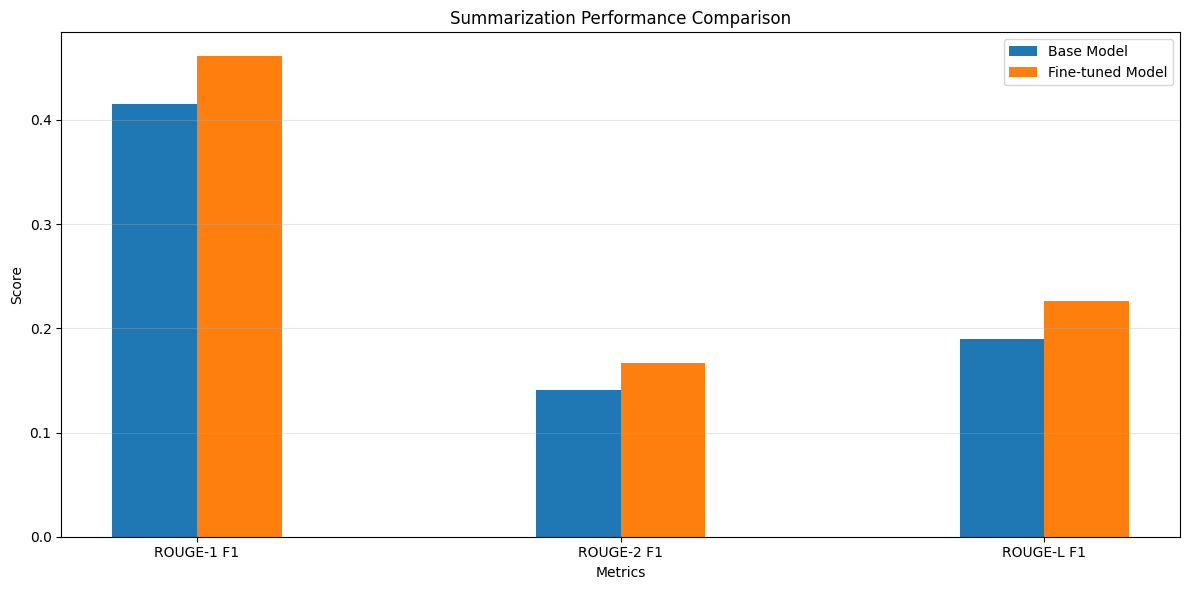

In [13]:
# Plot ROUGE and BERTScore metrics for both models
metrics_to_plot = ["ROUGE-1 F1", "ROUGE-2 F1", "ROUGE-L F1"]
models = comparison_df["Model"].tolist()

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(metrics_to_plot))

for i, model in enumerate(models):
    values = [comparison_df.loc[i, metric] for metric in metrics_to_plot]
    plt.bar(index + i*bar_width, values, bar_width, label=model)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Summarization Performance Comparison')
plt.xticks(index + bar_width/2, metrics_to_plot)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [14]:
# Calculate improvement from base to fine-tuned model
improvement_data = {}

for metric in ["ROUGE-1 F1", "ROUGE-2 F1", "ROUGE-L F1"]:
    base_value = comparison_df.loc[0, metric]
    finetuned_value = comparison_df.loc[1, metric]
    
    if not pd.isna(base_value) and not pd.isna(finetuned_value):
        abs_improvement = finetuned_value - base_value
        pct_improvement = (abs_improvement / base_value) * 100 if base_value > 0 else float('inf')
        
        improvement_data[metric] = {
            "Base Model": base_value,
            "Fine-tuned Model": finetuned_value,
            "Absolute Improvement": abs_improvement,
            "% Improvement": pct_improvement
        }

# Create DataFrame for improvement metrics
improvement_df = pd.DataFrame({
    "Metric": list(improvement_data.keys()),
    "Base Score": [improvement_data[m]["Base Model"] for m in improvement_data],
    "Fine-tuned Score": [improvement_data[m]["Fine-tuned Model"] for m in improvement_data],
    "Absolute Improvement": [improvement_data[m]["Absolute Improvement"] for m in improvement_data],
    "% Improvement": [f"{improvement_data[m]['% Improvement']:.2f}%" for m in improvement_data]
})

print("Improvement Analysis:")
improvement_df

Improvement Analysis:


,Metric,Base Score,Fine-tuned Score,Absolute Improvement,% Improvement
0,ROUGE-1 F1,0.415407,0.460939,0.045532,10.96%
1,ROUGE-2 F1,0.140741,0.166952,0.026210,18.62%
2,ROUGE-L F1,0.189347,0.225820,0.036473,19.26%


## Larger Training/Evaluation Results

If you were to train **Qwen3-4B-Instruct-2507** on **5000** samples and evaluate on **100** test items (total training time 32 mins on an ml.g5.12xlarge instance), you would see the following results:

![](./images/sft_5000_train_100_test_scores.png)

![](images/sft_5000_train_100_test_bars.png)

![](images/sft_5000_train_100_test_compare.png)


## Detailed Comparison Between Models

In [15]:
# Display example predictions from both models
num_examples = min(2, len(dataset))

for i in range(num_examples):
    print(f"\nExample {i+1}:")
    print(f"Question: {dataset[i]['Question']}")

    ref_cot_answer = '\n'.join([dataset[i]['Complex_CoT'],dataset[i]['Response']])
    print(f"\nReference CoT+Answer: {ref_cot_answer}")
    
    # Show predictions from both models
    print(f"\nBase Model Summary: {base_model_results['predictions'][i]}")
    print(f"\nFine-tuned Model Summary: {finetuned_model_results['predictions'][i]}")
    
    # Calculate ROUGE scores for this example using LightEval
    base_rouge = rouge_metrics.compute(golds=[ref_cot_answer], predictions=[base_model_results['predictions'][i]])
    finetuned_rouge = rouge_metrics.compute(golds=[ref_cot_answer], predictions=[finetuned_model_results['predictions'][i]])
    
    print("\nROUGE Scores (LightEval):")
    print(f"Base Model - ROUGE-1: {base_rouge['rouge1']:.4f}, ROUGE-2: {base_rouge['rouge2']:.4f}, ROUGE-L: {base_rouge['rougeL']:.4f}")
    print(f"Fine-tuned - ROUGE-1: {finetuned_rouge['rouge1']:.4f}, ROUGE-2: {finetuned_rouge['rouge2']:.4f}, ROUGE-L: {finetuned_rouge['rougeL']:.4f}")
    
    print("\n" + "="*80)


Example 1:
Question: Which hereditary disorder of bilirubin metabolism is caused by a defect in the MRP2 gene?

Reference CoT+Answer: Alright, let's dive into this. So, the MRP2 gene is really interesting because it codes for a protein that belongs to the ABC transporter family. This protein plays a huge role in the liver by moving stuff around, including something called conjugated bilirubin, from inside liver cells into the bile. 

Now, why is this important? Well, you see, bilirubin metabolism relies heavily on this process. Without proper transport of conjugated bilirubin, it can't get from the liver to the bile duct, and then ultimately out of the body. This step is crucial; otherwise, you end up with bilirubin building up in the liver and bloodstream. And we definitely don't want that because it leads to elevated levels in the blood.

If the MRP2 gene has some defects or mutations, this transport process gets messed up. Imagine what's supposed to be a smooth highway has now got 

# Clean Up Endpoints

Run the following code to clean up your base endpoint. It is no longer needed.

In [ ]:
sagemaker_client = boto3.client('sagemaker')

delete_base_response = sagemaker_client.delete_endpoint(
    EndpointName=BASE_ENDPOINT_NAME
)

print(delete_base_response)

In [ ]:
delete_basecfg_response = sagemaker_client.delete_endpoint_config(
    EndpointConfigName=BASE_ENDPOINT_NAME
)
print(delete_basecfg_response)